# Minimal code for Extended Data Figure 1b flow cytometry panel

In [1]:
# library for reading .fcs files
suppressPackageStartupMessages(library(flowCore))
# library for extracting statistical fits
suppressPackageStartupMessages(library(broom))
# standard analysis and plotting functions, includes dplyr, ggplot2
suppressPackageStartupMessages(library(tidyverse))
# loads lab default ggplot2 theme and provides color-blind friendly palette
suppressPackageStartupMessages(library(rasilabRtemplates))
# this folder contains the data and annotations
fcs_file_folder <- "../../../../data/flow_cytometry/figs1b_integration_efficiency_u2os_293t/"
# nice channel names
channels <- c(
  "fitc_a" = "yfp", "pe_texas_red_a" = "rfp",
  "bv421_a" = "bfp"
)

In [2]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Read in annotations

In [9]:
annotations <- read_csv("../annotations/sample_annotations.csv", show_col_types = F) %>% 
  mutate(file = as.character(file)) %>%
  print()

# A tibble: 4 × 3
  file  cell_line sgrna   
  <chr> <chr>     <chr>   
1 1     293T      Reporter
2 9     U2OS      Reporter
3 64    293T      None    
4 280   U2OS      None    


## Read in flow data

In [5]:
flowdata  <- list.files(fcs_file_folder, full.names = T, pattern = ".fcs") %>% 
  as_tibble_col("file") %>%
  mutate(data = map(file, . %>% read.FCS(transformation = F, alter.names = T) %>% exprs %>% as_tibble)) %>%
  mutate(file = str_extract(file, "(?<=001_)[:graph:]+(?=.fcs$)")) %>%
  unnest("data") %>%
  janitor::clean_names() %>%
  rename_with(. %>% channels[.], names(channels)) %>%
  select(-time, -yfp, -fsc_a) %>%
  print()

# A tibble: 40,000 × 4
   file   ssc_a    bfp    rfp
   <chr>  <dbl>  <dbl>  <dbl>
 1 1      9033. 3046.   39.7 
 2 1      7672. 4321.    8.60
 3 1      6014. 4951.   -3.29
 4 1      6138. 4528.   31.1 
 5 1      6111.  116.   19.7 
 6 1      6694. 4206.  -29.7 
 7 1      6143.  538.   22.6 
 8 1      5236.   72.7  27.7 
 9 1     10416. 7986.    1.32
10 1     12903. 8630.   39.7 
# … with 39,990 more rows


## Join data with annotations

In [10]:
data <- flowdata %>%
  inner_join(annotations, by = "file") %>%
  mutate(cell_line = fct_relevel(cell_line, "293T", "U2OS")) %>% 
  print()

# A tibble: 40,000 × 6
   file   ssc_a    bfp    rfp cell_line sgrna   
   <chr>  <dbl>  <dbl>  <dbl> <fct>     <chr>   
 1 1      9033. 3046.   39.7  293T      Reporter
 2 1      7672. 4321.    8.60 293T      Reporter
 3 1      6014. 4951.   -3.29 293T      Reporter
 4 1      6138. 4528.   31.1  293T      Reporter
 5 1      6111.  116.   19.7  293T      Reporter
 6 1      6694. 4206.  -29.7  293T      Reporter
 7 1      6143.  538.   22.6  293T      Reporter
 8 1      5236.   72.7  27.7  293T      Reporter
 9 1     10416. 7986.    1.32 293T      Reporter
10 1     12903. 8630.   39.7  293T      Reporter
# … with 39,990 more rows


## Plot BFP vs mCherry fluorescence

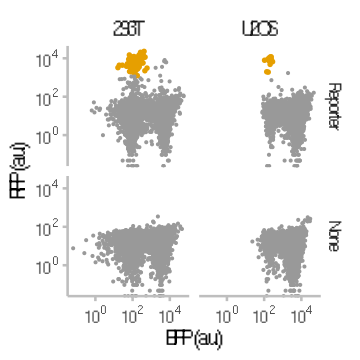

In [ ]:
options(repr.plot.width=3, repr.plot.height=3, warn=-1)

# As scatter
data %>%
  mutate(color = if_else(bfp < 950 & rfp > 1200, "red", "black")) %>%
  ggplot(aes(x = bfp, y = rfp, color = color, size = color)) +
  facet_grid(fct_rev(sgrna) ~ cell_line, scales = "fixed", labeller = "label_value") +
  geom_point() +
  scale_size_manual(values = c(0.1, 0.5)) +
  scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
  scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
  theme(axis.line = element_line(color = "grey"), axis.ticks = element_line(color = "grey")) +
  guides(color = FALSE, size = FALSE) +
  labs(x = "BFP (a.u.)", y = "RFP (a.u.)") 

ggsave("../figures/bfp_vs_rfp.pdf", width = 3, height = 3, units = "in")

In [19]:
data %>% 
  mutate(color = if_else(bfp < 950 & rfp > 1200, "red", "black")) %>%
  group_by(cell_line, sgrna, color) %>%
  count() %>%
  mutate(percent = round(n/100, 1))

cell_line,sgrna,color,n,percent
<fct>,<chr>,<chr>,<int>,<dbl>
293T,None,black,10000,100.0
293T,Reporter,black,9886,98.9
293T,Reporter,red,114,1.1
U2OS,None,black,10000,100.0
U2OS,Reporter,black,9986,99.9
U2OS,Reporter,red,14,0.1


In [15]:
top_left <- data %>%
    filter(rfp > 1200 & bfp < 950) %>% 
    group_by(file, cell_line, sgrna) %>%
    count() %>%
    mutate(top_left_percent = n/100) %>%
    arrange(cell_line, sgrna)

top_left

file,cell_line,sgrna,n,top_left_percent
<chr>,<fct>,<chr>,<int>,<dbl>
1,293T,Reporter,114,1.14
9,U2OS,Reporter,14,0.14
